# **Preparing Data**

In [ ]:
# DNN library is not found

!pip install tensorflow==2.7.0

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [3]:
# Origin Code
# train_data = pd.read_csv(DATA_IN_PATH + '/ratings_train.txt', header = 0, delimiter = '\t', quoting=3)
# train_data.head()
DATA_IN_PATH = './data_in'
train_data = pd.read_csv(DATA_IN_PATH + '/ChatbotDataClassifier.csv', header = 0, delimiter = ',', quoting=3)
train_data.head()

,Q,A,label
0,우리 기간 언제까지나고 물어볼 수 없어 재등록 할 줄 알면 어케?,헉 어떻게말해야되지?,0
1,그냥 자연스레 안나오면되비 ㄱ 아저씨가 먼저 말하려나? 연장할거냐고하면 뭐랗9?,고민해볼게요? 생각해보고나올게요? 대본짜줘,0
2,다음 달은 바빠서 어려울 것 같고 다음번에 다시 올게요~ 어떠니??,오 역시말을잘하네 너가말해!,0
3,아침,헉,0
4,잘안먹구,일찍 인나짜나,0


In [4]:
print('전체 학습 데이터의 개수: {}'.format(len(train_data)))

전체 학습 데이터의 개수: 59997


In [5]:
train_length = train_data['Q'].astype(str).apply(len)
train_length.head()

0    36
1    44
2    37
3     2
4     4
Name: Q, dtype: int64

Text(0.5, 0, 'Number of review')

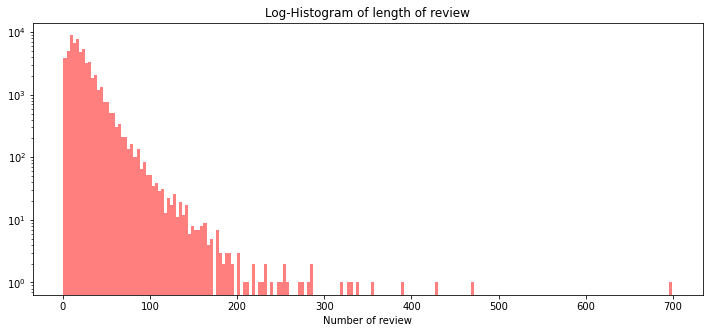

In [6]:
# 그래프에 대한 이미지 크기 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값에 대한 버킷 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')

# 그래프 제목
plt.title('Log-Histogram of length of review')

# 그래프 x축 라벨
plt.xlabel('Length of review')
# 그래프 y축 라벨
plt.xlabel('Number of review')

# **데이터 전처리**

In [ ]:
pip install konlpy

In [8]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

DATA_IN_PATH = './data_in'

# Origin Code
# train_data = pd.read_csv(DATA_IN_PATH + '/ratings_train.txt', header=0, delimiter='\t', quoting=3)

train_data = pd.read_csv(DATA_IN_PATH + '/ChatbotDataClassifier.csv', header=0, delimiter=',', quoting=3)

In [9]:
train_data['Q'][:5]
train_data['label'][:5]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [10]:
# review: 전처리할 텍스트
def preprocessing(review):
  FILTER = re.compile("([~.,!\"':;)(])")
  review = FILTER.sub('', review)

  sequences_input_index = []
  for sequence in review.split():
    sequences_input_index.append(sequence)

  return sequences_input_index

In [11]:
clean_train_review = []

# Origin Code: train_data['document']
for review in train_data['Q']:
  # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
  if type(review) == str:
    clean_train_review.append(preprocessing(review))
  else:
    clean_train_review.append([])  # string이 아니면 비어있는 값 추가

clean_train_review[:4] # 앞의 4개 데이터 확인

[['우리', '기간', '언제까지나고', '물어볼', '수', '없어', '재등록', '할', '줄', '알면', '어케?'],
 ['그냥', '자연스레', '안나오면되비', 'ㄱ', '아저씨가', '먼저', '말하려나?', '연장할거냐고하면', '뭐랗9?'],
 ['다음', '달은', '바빠서', '어려울', '것', '같고', '다음번에', '다시', '올게요', '어떠니??'],
 ['아침']]

In [12]:
# Origin Code
test_data = pd.read_csv(DATA_IN_PATH + '/ChatbotDataClassifierTest.csv', header=0, delimiter=',', quoting=3)

clean_test_review = []

for review in test_data['Q']:
  if type(review) == str:
    clean_test_review.append(preprocessing(review))
  else:
    clean_test_review.append([])

clean_test_review[:4]

[['ㅋㅋㅋㅋㅋㅋㅋㅋㅋ'],
 ['근데요', '내가', '진짜로', '힘이', '너무', '없네요', '카톡하기도', '버거워요'],
 ['아아', '짜증나ㅜㅠㅠㅠㅠ', '너무', '힘들어'],
 ['으아아ㅏ', 'ㅠㅠㅠㅠㅠㅠ', '자고', '일어났어요', '근디', '손떨리네']]

In [13]:
# 단어 사전 만들기
FILTERS = "([~.,!\"':;)(])"
PAD="<PAD>"			# 어떤 의미도 없는 패딩토큰
STD="<SOS>" 		# 시작 토근을 의미
END="<END>"			# 종료 토큰을 의미
UNK="<UNK>" 		# 사전에 없는 단어를 의미

PAD_INDEX=0
STD_INDEX=1
END_INDEX=2
UNK_INDEX=3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

def data_tokenizer(data):
	words = []
	for sentence in data:
		# Origin Code
		sentence = re.sub(CHANGE_FILTER, "", str(sentence))  # 정규표현식을 사용하여 특수 기호를 모두 제거
	
		for word in sentence.split():
			words.append(word)
	return [word for word in words if word]

def make_vocabulary(vocabulary_list):
	# 리스트를 키가 단어이고 값이 인덱스인 딕셔너리를 만듬
	char2idx = {char:idx for idx, char in enumerate(vocabulary_list)}   # enumerate: index와 원소로 이뤄진 tuple을 생성 Ex] (0, 'A') (1, 'B')

	# 키가 인덱스이고 값이 단어인 딕셔너리를 만듬
	idx2char = {idx: char for idx, char in enumerate(vocabulary_list)}

	return char2idx, idx2char

def load_vocabulary(path, vocab_path):
	vocabulary_list = []

	if not os.path.exists(vocab_path):
		if (os.path.exists(path)):

			data_df = pd.read_csv(path, delimiter=',', header=0, quoting=3, encoding='utf-8')
			document = list(data_df['Q'])
			
			data = []
			data.extend(document)  # extend를 통해 구조가 없는 배열로 만듬

			words = data_tokenizer(data)
			words = list(set(words))  # set(): 중복 제거
			words[:0] = MARKER    # Tokenizing된 단어 리스트의 앞에 MARKER를 추가

		with open(vocab_path, 'w', encoding='utf-8') as vocabulary_file:
			for word in words:
				vocabulary_file.write(word + '\n')

	with open(vocab_path, 'r', encoding='utf-8') as vocabulary_file:
		for line in vocabulary_file:
			vocabulary_list.append(line.strip())  # strip(): 양옆의 공백 제거

	# char2idx: 단어에 대한 인덱스 (Dictionary Type)
	# idx2char: 인덱스에 대한 단어 (Dictionary Type)
	char2idx, idx2char = make_vocabulary(vocabulary_list)

	return char2idx, idx2char, len(char2idx)

In [14]:
PATH = DATA_IN_PATH + '/ChatbotDataClassifier.csv'
VOCAB_PATH = 'data_in/vocabulary.txt'

char2idx, idx2char, vocab_size = load_vocabulary(PATH, VOCAB_PATH)

In [15]:
MAX_SEQUENCE = 25

def pad_sequences(inputs, dictionary):
  sequences_input_index = []

  for sequences in inputs:
    sequence_index = []
    for word in sequences:
      if dictionary.get(word) is not None:
        sequence_index.extend([dictionary[word]])
      else:
        sequence_index.extend([dictionary[UNK]])
    
    # 최대 허용치 넘을경우 자르기
    if len(sequence_index) > MAX_SEQUENCE:
      sequence_index = sequence_index[:MAX_SEQUENCE]

    # 최대 허용치 넘지 않을 경우 PAD 넣기
    sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]

    sequences_input_index.append(sequence_index)

  return np.asarray(sequences_input_index)

In [16]:
train_inputs = pad_sequences(clean_train_review, char2idx)
train_inputs

array([[ 56502,  54693, 108480, ...,      0,      0,      0],
       [119129, 114225,  79534, ...,      0,      0,      0],
       [ 46166,  64726,  46778, ...,      0,      0,      0],
       ...,
       [104193, 114342,      0, ...,      0,      0,      0],
       [128733,  28779,      0, ...,      0,      0,      0],
       [ 27025,      0,      0, ...,      0,      0,      0]])

In [17]:
train_labels = np.array(train_data['label'])
train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [18]:
test_inputs = pad_sequences(clean_test_review, char2idx)
test_inputs

array([[ 95878,      0,      0, ...,      0,      0,      0],
       [     3,  86043,   1970, ...,      0,      0,      0],
       [125740,      3,  88170, ...,      0,      0,      0],
       ...,
       [ 15384,  63150, 113489, ...,      0,      0,      0],
       [ 59431,  12249, 120214, ...,      0,      0,      0],
       [ 65978,  70896,  28536, ...,      0,      0,      0]])

In [19]:
test_labels = np.array(test_data['label'])

In [20]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}
data_configs['vocab'] = char2idx
data_configs['vocab_size'] = len(char2idx) + 1

import os

# 저장하는 디렉터리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
  os.makedirs(DATA_IN_PATH)

# 전처리된 학습 데이터를 numpy 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
# 전처리된 평가 데이터를 numpy 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

# **모델링**

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [22]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

**파라미터 정의**

In [ ]:
model_name = 'rnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_size': 128,
         'num_filters': 100,
         'dropout_rate': 0.5,
         'hidden_dimension': 250,
         'output_dimension': 1}

In [ ]:
from tensorflow.keras.utils import to_categorical

train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

# **RNN 모델 학습**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 128
hidden_units = 128
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(train_input, 
                    train_label, 
                    batch_size=128, 
                    epochs=3, 
                    callbacks=[es, mc], 
                    validation_data=(test_input, test_label))

Epoch 1/3
469/469 [==============================] - ETA: 0s - loss: 1.0361 - acc: 0.4117
Epoch 00001: val_acc improved from -inf to 0.65851, saving model to best_model.h5
469/469 [==============================] - 141s 297ms/step - loss: 1.0361 - acc: 0.4117 - val_loss: 0.7866 - val_acc: 0.6585
Epoch 2/3
469/469 [==============================] - ETA: 0s - loss: 0.7107 - acc: 0.6626
Epoch 00002: val_acc improved from 0.65851 to 0.76292, saving model to best_model.h5
469/469 [==============================] - 139s 296ms/step - loss: 0.7107 - acc: 0.6626 - val_loss: 0.5145 - val_acc: 0.7629
Epoch 3/3
469/469 [==============================] - ETA: 0s - loss: 0.2478 - acc: 0.9071
Epoch 00003: val_acc improved from 0.76292 to 0.85972, saving model to best_model.h5
469/469 [==============================] - 141s 300ms/step - loss: 0.2478 - acc: 0.9071 - val_loss: 0.4159 - val_acc: 0.8597


In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_input, test_label)[1]))

938/938 [==============================] - 15s 16ms/step - loss: 0.4041 - acc: 0.8539

 테스트 정확도: 0.8539


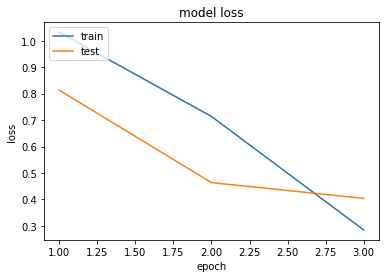

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         16656000  
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 16,787,971
Trainable params: 16,787,971
Non-trainable params: 0
_________________________________________________________________


# **CNN 모델 학습**

In [60]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_size': 128,
         'num_filters': 100,
         'dropout_rate': 0.5,
         'hidden_dimension': 250,
         'output_dimension': 3}

In [61]:
class CNNClassifier(tf.keras.Model):
  def __init__(self, **kargs):
    super(CNNClassifier, self).__init__(name=kargs['model_name'])
    self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_size'])
    self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], 
                                    kernel_size=kernel_size, 
                                    padding='valid', 
                                    activation=tf.keras.activations.relu,
                                    kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) for kernel_size in [3,4,5]]
    self.pooling = layers.GlobalMaxPooling1D()
    self.dropout = layers.Dropout(kargs['dropout_rate'])
    self.fc1 = layers.Dense(units=kargs['hidden_dimension'], 
                            activation=tf.keras.activations.relu, 
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    self.fc2 = layers.Dense(units=kargs['output_dimension'], 
                            activation=tf.keras.activations.softmax, 
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
  def call(self, x):
    x = self.embedding(x)
    x = self.dropout(x)
    x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
    x = self.fc1(x)
    x = self.fc2(x)

    return x

In [63]:
model = CNNClassifier(**kargs)

# Origin Code
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_one_hot = to_categorical(train_label)
test_one_hot = to_categorical(test_label)

In [64]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
  print("{} - Folder already exists \n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} - Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(train_input, 
                    train_one_hot, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_split=VALID_SPLIT, 
                    callbacks=[earlystop_callback, cp_callback])

./data_out/cnn_classifier_kr - Folder already exists 

Epoch 1/20
104/106 [============================>.] - ETA: 0s - loss: 1.0664 - accuracy: 0.4120
Epoch 00001: val_accuracy improved from -inf to 0.05317, saving model to ./data_out/cnn_classifier_kr/weights.h5
106/106 [==============================] - 3s 23ms/step - loss: 1.0653 - accuracy: 0.4125 - val_loss: 1.1616 - val_accuracy: 0.0532
Epoch 2/20
106/106 [==============================] - ETA: 0s - loss: 0.7946 - accuracy: 0.6412
Epoch 00002: val_accuracy improved from 0.05317 to 0.29650, saving model to ./data_out/cnn_classifier_kr/weights.h5
106/106 [==============================] - 2s 21ms/step - loss: 0.7946 - accuracy: 0.6412 - val_loss: 1.2581 - val_accuracy: 0.2965
Epoch 3/20
106/106 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8596
Epoch 00003: val_accuracy improved from 0.29650 to 0.40217, saving model to ./data_out/cnn_classifier_kr/weights.h5
106/106 [==============================] - 2s 21

In [66]:
model.evaluate(test_input, test_one_hot)

938/938 [==============================] - 3s 3ms/step - loss: 0.5926 - accuracy: 0.7973


[0.5925694108009338, 0.7973198294639587]

# **TEST**

In [67]:
MAX_SEQUENCE = 25

def enc_preprocess(value, dictionary):
  sequences_input_indexs = []
  sequences_input_index = []
  sequences_length = []

  for word in value.split():
    if dictionary.get(word) is not None:
      sequences_input_index.extend([dictionary[word]])
    else:
      sequences_input_index.extend([dictionary[UNK]])

  if len(sequences_input_index) > MAX_SEQUENCE:
    sequence_index = sequences_input_index[:MAX_SEQUENCE]

  sequences_length.append(len(sequences_input_index))
  sequences_input_index += (MAX_SEQUENCE - len(sequences_input_index)) * [dictionary[PAD]]

  sequences_input_indexs.append(sequences_input_index)

  return sequences_input_indexs, sequences_length

In [72]:
test_text = "근데 언제할지 모르겠어 사실 나도"
test_input, _ = enc_preprocess(test_text, char2idx)

In [73]:
inputs = np.array(test_input)
print(inputs)
print(inputs.shape)

digit = model.predict(inputs)
print(digit)

[[118911 104481  22260 119371 109704      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]]
(1, 25)
[[0.03223016 0.01104609 0.9567237 ]]


# **Export the model**

In [74]:
import tensorflow as tf

TEXTS_CLASSIFICATION = "exp_saved_model"
tf.saved_model.save(model, TEXTS_CLASSIFICATION)

In [75]:
loaded = tf.saved_model.load(TEXTS_CLASSIFICATION)

print(list(loaded.signatures.keys()))

['serving_default']


In [76]:
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

((), {'input_1': TensorSpec(shape=(None, 25), dtype=tf.int32, name='input_1')})
{'output_1': TensorSpec(shape=(None, 3), dtype=tf.float32, name='output_1')}


# **Convert using TFLite's Converter**

In [77]:
converter = tf.lite.TFLiteConverter.from_saved_model(TEXTS_CLASSIFICATION)

In [78]:
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

# **Test the TFLite model using the Python Interpreter**

In [79]:
import tensorflow as tf
tflite_model_file = 'converted_model.tflite'

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
print(input_details)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 25], dtype=int32), 'shape_signature': array([-1, 25], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [83]:
test_text = "근데 언제할지 모르겠어 사실 나도"
test_input, _ = enc_preprocess(test_text, char2idx)
# inputs = tf.cast(test_input, dtype=tf.float32)
# print(inputs.shape)

inputs = np.array(test_input, dtype=np.int32)
# input_flatten = inputs.flatten()
# print(input_flatten.shape)

# print(inputs)
# print(inputs.shape)

interpreter.set_tensor(input_index, inputs)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

print(predictions)

[[0.03223016 0.01104608 0.9567238 ]]
